# EEL891 - Aprendizado de Máquina 

-----------------------------------------------------------------------
### Objetivos do trabalho:

 * participar da competição no kaggle: "House Prices: Advanced Regression Techniques"
 
 * Realizar devido tratamento dos dados
 
 * Escolher modelo que será utilizado para regressão
 
 * Apresentar relatório e resultados
 

 -----

### Bibliotecas necessárias para o código:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

----

## Aquisição dos dados

In [2]:
data_train = pd.read_csv('../data/train.csv')
#data_train = pd.read_csv('../../ames.csv').drop('PID', axis = 1)
data_test = pd.read_csv('../data/test.csv')
data_test['SalePrice'] = -1

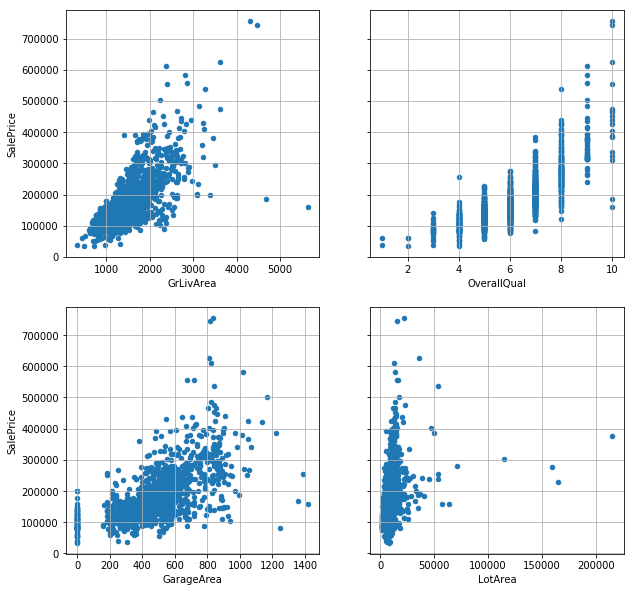

In [3]:
colnames = ['GrLivArea','OverallQual','GarageArea','LotArea']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i//2, i%2], sharey = True, grid = True)

### Removendo os outliers como descrito na documentação do dataset

* https://ww2.amstat.org/publications/jse/v19n3/decock/DataDocumentation.txt

In [4]:
data_train = data_train[data_train['GrLivArea'] < 4000]
data_train = data_train[data_train['GarageArea'] < 1200]
data_train = data_train[data_train['LotArea'] < 100000]
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))

Train shape: (1448, 81)
Test shape: (1459, 81)


In [5]:
target = data_train['SalePrice']
train_ids = data_train['Id'].values
test_ids = data_test['Id'].values
removed_cols = []

all_data = pd.concat((data_train, data_test))
all_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
target.describe()

count      1448.000000
mean     179716.818370
std       76357.584764
min       34900.000000
25%      129900.000000
50%      162700.000000
75%      213310.000000
max      625000.000000
Name: SalePrice, dtype: float64

In [7]:
all_data.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object)

In [8]:
all_data.select_dtypes(include=['int64', 'float64']).columns.values

array(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'], dtype=object)

In [9]:
all_data.select_dtypes(exclude=['int64', 'float64']).columns.values

array(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
       'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish',
       'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence',
       'MiscFeature', 'SaleType', 'SaleCondition'], dtype=object)

* Lendo a descrição do dataset, podemos perceber que MSSubClass é uma variável categórica, apesar de ser tratada numericamente, assim, transformamos em uma string para depois aplicar o LabelEncoder e OneHotEncoder facilmente

In [10]:
all_data['MSSubClass'] = all_data['MSSubClass'].transform(lambda x: str(x)).astype(str)

* Também podemos perceber que as variáveis ExterQual, ExterCond, BsmtQual, BsmtCond, HeatingQC, KitchenQual, FireplaceQu, GarageQual, GarageCond e PoolQC, apesar de a princípio parecerem variáveis categóricas, podem ser representadas por variáveis numéricas, pois seus níveis (NA, Po, Fa, TA, Gd, Ex) tem uma relação de ordem e superioridade/inferioridade entre um e outro. Assim, podemos mapeá-los da seguinte forma:  {NA: 0, Po: 1, Fa: 2, TA: 3, Gd: 4, Ex: 5}
* O mesmo acontece para as variáveis LandSlope, BsmtExposure, BsmtFinType1, BsmtFinType2, Functional, GarageFinish, PavedDrive e Fence

In [11]:
grades_map = {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
def map_grade(grade):
    if isinstance(grade, float) and np.isnan(grade): return grade
    return grades_map[grade]

landslope_map = {'Gtl': 0, 'Mod': 1, 'Sev': 2}
def map_landslope(slope):
    if isinstance(slope, float) and np.isnan(slope): return slope
    return landslope_map[slope]

bsmtexposure_map = {'No': 0, 'Mn': 1, 'Av': 2, 'Gd': 3}
def map_bsmtexposure(exposure):
    if isinstance(exposure, float) and np.isnan(exposure): return exposure
    return bsmtexposure_map[exposure]

bsmtfintype_map = {'Unf': 0, 'LwQ': 1, 'Rec': 2, 'BLQ': 3, 'ALQ': 4, 'GLQ': 5}
def map_bsmtfintype(fintype):
    if isinstance(fintype, float) and np.isnan(fintype): return fintype
    return bsmtfintype_map[fintype]

functional_map = {'Typ': 0, 'Min1': 1, 'Min2': 2, 'Mod': 3, 'Maj1': 4, 'Maj2': 5, 'Sev': 6, 'Sal': 7}
def map_functional(functional):
    if isinstance(functional, float) and np.isnan(functional): return functional
    return functional_map[functional]

garagefin_map = {'Unf': 0, 'RFn': 1, 'Fin': 2}
def map_garagefin(garagefin):
    if isinstance(garagefin, float) and np.isnan(garagefin): return garagefin
    return garagefin_map[garagefin]

pave_map = {'N': 0, 'P': 1, 'Y': 2}
def map_pave(pave):
    if isinstance(pave, float) and np.isnan(pave): return pave
    return pave_map[pave]

fence_map = {'NA': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
def map_fence(fence):
    if isinstance(fence, float) and np.isnan(fence): return fence
    return fence_map[fence]

for col in ('ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC'):
    all_data[col] = all_data[col].transform(map_grade).astype(float)

all_data['LandSlope']    = all_data['LandSlope'].transform(map_landslope).astype(float)
all_data['BsmtExposure'] = all_data['BsmtExposure'].transform(map_bsmtexposure).astype(float)
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].transform(map_bsmtfintype).astype(float)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].transform(map_bsmtfintype).astype(float)
all_data['Functional']   = all_data['Functional'].transform(map_functional).astype(float)
all_data['GarageFinish'] = all_data['GarageFinish'].transform(map_garagefin).astype(float)
all_data['PavedDrive']   = all_data['PavedDrive'].transform(map_pave).astype(float)
all_data['Fence']        = all_data['Fence'].transform(map_fence).astype(float)

* Como encontrado na descrição do dataset, podemos utilizar dados auxiliares para transformar os bairros em seus multiplicadores
* https://ww2.amstat.org/publications/jse/v19n3/decock/AmesResidential.pdf

In [12]:
neighborhood_map = {'CollgCr': 98, 'Veenker': 98, 'Crawfor': 106, 'NoRidge': 101, 'Mitchel': 99, 'Somerst': 101,
                    'NWAmes': 99, 'OldTown': 102, 'BrkSide': 106, 'Sawyer': 101, 'NridgHt': 104, 'NAmes': 100,
                    'SawyerW': 98, 'IDOTRR': 102, 'MeadowV': 90, 'Edwards': 98, 'Timber': 103, 'Gilbert': 97,
                    'StoneBr': 104, 'ClearCr': 103, 'NPkVill': 109, 'Blmngtn': 105, 'BrDale': 105, 'SWISU': 99 ,
                    'Blueste': 99}
def map_neighborhood(neighborhood):
    if isinstance(neighborhood, float) and np.isnan(neighborhood): return neighborhood
    return neighborhood_map[neighborhood]

all_data['Neighborhood'] = all_data['Neighborhood'].transform(map_neighborhood).astype(float)

,SalePrice,Neighborhood
SalePrice,1.000000,0.050392
Neighborhood,0.050392,1.000000


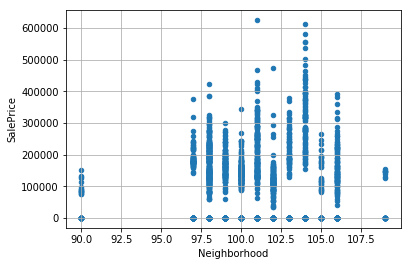

In [13]:
data = pd.concat([all_data['SalePrice'], all_data['Neighborhood']], axis=1).dropna()

data.plot.scatter(x = 'Neighborhood', y = 'SalePrice', grid = True)

data.corr().sort_values(by = 'SalePrice', ascending = False)

* Separando as variáveis numéricas e categóricas:

In [14]:
numerical_cols = all_data.select_dtypes(include=['int64', 'float64']).drop('Id', axis = 1).columns.values
categorical_cols = all_data.select_dtypes(exclude=['int64', 'float64']).columns.values
print('Numerical: ')
print(numerical_cols)
print('Categorical: ')
print(categorical_cols)

Numerical: 
['LotFrontage' 'LotArea' 'LandSlope' 'Neighborhood' 'OverallQual'
 'OverallCond' 'YearBuilt' 'YearRemodAdd' 'MasVnrArea' 'ExterQual'
 'ExterCond' 'BsmtQual' 'BsmtCond' 'BsmtExposure' 'BsmtFinType1'
 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2' 'BsmtUnfSF' 'TotalBsmtSF'
 'HeatingQC' '1stFlrSF' '2ndFlrSF' 'LowQualFinSF' 'GrLivArea'
 'BsmtFullBath' 'BsmtHalfBath' 'FullBath' 'HalfBath' 'BedroomAbvGr'
 'KitchenAbvGr' 'KitchenQual' 'TotRmsAbvGrd' 'Functional' 'Fireplaces'
 'FireplaceQu' 'GarageYrBlt' 'GarageFinish' 'GarageCars' 'GarageArea'
 'GarageQual' 'GarageCond' 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF'
 'EnclosedPorch' '3SsnPorch' 'ScreenPorch' 'PoolArea' 'PoolQC' 'Fence'
 'MiscVal' 'MoSold' 'YrSold' 'SalePrice']
Categorical: 
['MSSubClass' 'MSZoning' 'Street' 'Alley' 'LotShape' 'LandContour'
 'Utilities' 'LotConfig' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType'
 'Foundation' 'Heating' 'CentralAir' 'Electrical' 

In [15]:
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))

Train shape: (1448, 81)
Test shape: (1459, 81)


---

# Dados Faltantes

* Contando os dados faltantes

In [16]:
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()*100/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data['Total'] > 0].round({'Percent': 2})

,Total,Percent
PoolQC,2899,99.72
MiscFeature,2805,96.49
Alley,2709,93.19
Fence,2337,80.39
FireplaceQu,1419,48.81
LotFrontage,482,16.58
GarageCond,159,5.47
GarageYrBlt,159,5.47
GarageFinish,159,5.47
GarageQual,159,5.47


* Escolhemos ignorar as variáveis com mais de 30% dos dados faltantes, pois com tantos dados faltantes a variável não é uma boa descritora do preço de venda ou então uma tentativa de aproximação pode gerar muitos erros
* Para o caso da piscina, como há apenas 5 amostras no dataset de treino, também ignoramos a variável poolArea

In [17]:
all_data.drop(missing_data[missing_data['Percent'] > 30].index, axis = 1, inplace = True)

all_data.drop('PoolArea', axis = 1, inplace = True)

* Para o dado LotFrontage, assumimos que a area frontal do terreno é igual à mediana da área frontal dos terrenos da mesma vizinhança da amostra

In [18]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))

* Para as informações relativas à garagem, os dados faltantes indicam que a casa não possui garagem. Assim, substituimos os valores por None (categóricos) ou 0 (numéricos). Para o caso do ano de construção da garagem, repetimos o ano de construção da casa

In [19]:
for column in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageArea', 'GarageCars'):
    if column in numerical_cols:
        all_data[column].fillna(0, inplace = True)
    else:
        all_data[column].fillna('None', inplace = True)

all_data['GarageYrBlt'].fillna(all_data['YearBuilt'], inplace = True)
index = all_data[all_data['GarageYrBlt'] > max(all_data['YearBuilt'])]['GarageYrBlt'].index
all_data.iloc[index]['GarageYrBlt'] = 2007#all_data.iloc[index]['YearBuilt']
all_data.iloc[index]['GarageYrBlt']
#all_data = all_data[all_data['GarageYrBlt'] <= max(all_data['YearBuilt'])]

1141    1976.0
Name: GarageYrBlt, dtype: float64

* Para as variáveis Bsmt\[...\], realizamos o tratamento de forma similar ao tratamento das variáveis de garagem

In [20]:
for column in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    if column in numerical_cols:
        all_data[column].fillna(0, inplace = True)
    else:
        all_data[column].fillna('None', inplace = True)

* Para as variáveis MasVnrType e MasVnrArea, dados faltantes representam que não há alvenaria, então substituímos por None ou 0

In [21]:
all_data["MasVnrType"].fillna("None", inplace = True)
all_data["MasVnrArea"].fillna(0, inplace = True)

* Para as variaveis MSZoning, SaleType, Utilities e Functional substituimos pela moda

In [22]:
all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0], inplace = True)
all_data['SaleType'].fillna(all_data['SaleType'].mode()[0], inplace = True)
all_data['Utilities'].fillna(all_data['Utilities'].mode()[0], inplace = True)
all_data['Functional'].fillna(all_data['Functional'].mode()[0], inplace = True)

* Para as variáveis Electrical, Exterior1st, Exterior2nd e KitchenQual, utilizamos a moda das construções na mesma vizinhança da amostra faltante

In [23]:
for column in ('Electrical', 'Exterior1st', 'Exterior2nd', 'KitchenQual'):
    all_data[column] = all_data.groupby('Neighborhood')[column].transform(
        lambda x: x.fillna(x.mode()[0]))

In [24]:
total_after = all_data.isnull().sum().sort_values(ascending=False)
print('Não há mais dados faltantes') if total_after[total_after > 0].empty else print(total_after[total_after > 0]) 

Não há mais dados faltantes


* Por fim, adicionamos uma variável auxiliar, a área interna total do imóvel (diferente de GrLivArea, que desconsidera a área no subsolo)

In [25]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

* Separando novamente o dataset:

In [26]:
data_train = all_data[all_data['SalePrice'] > 0]
data_test = all_data[all_data['SalePrice'] < 0]
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))
numerical_cols = all_data.select_dtypes(include=['int64', 'float64']).drop('Id', axis = 1).columns.values
categorical_cols = all_data.select_dtypes(exclude=['int64', 'float64']).columns.values

Train shape: (1448, 76)
Test shape: (1459, 76)


,SalePrice,Neighborhood,GrLivArea,TotalSF,OverallQual,Test_GrLivArea,Test_TotalSF,Test_OverallQual
SalePrice,1.000000,0.153983,0.719694,0.823459,0.802012,0.727990,0.829100,0.804809
Test_TotalSF,0.829100,0.205552,0.855701,0.995751,0.677500,0.864657,1.000000,0.687697
TotalSF,0.823459,0.119081,0.860378,1.000000,0.674258,0.861565,0.995751,0.673601
Test_OverallQual,0.804809,0.249010,0.580725,0.673601,0.992541,0.595914,0.687697,1.000000
OverallQual,0.802012,0.132426,0.583466,0.674258,1.000000,0.588671,0.677500,0.992541
Test_GrLivArea,0.727990,0.176111,0.996316,0.861565,0.588671,1.000000,0.864657,0.595914
GrLivArea,0.719694,0.095957,1.000000,0.860378,0.583466,0.996316,0.855701,0.580725
Neighborhood,0.153983,1.000000,0.095957,0.119081,0.132426,0.176111,0.205552,0.249010


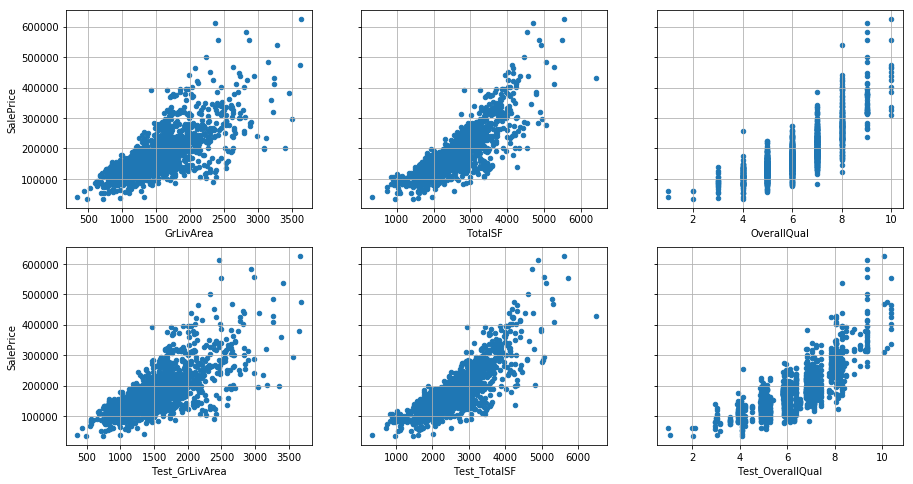

In [27]:
colnames = ['GrLivArea', 'TotalSF', 'OverallQual']
data = pd.concat([data_train['SalePrice'], data_train['Neighborhood'], data_train[colnames]], axis=1)

# data['SalePrice'] = data['SalePrice']*100/data['Neighborhood']
fig, axes = plt.subplots(2, len(colnames), figsize=(5*len(colnames), 8))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[0, i], sharey = True, grid = True)
    data[('Test_' + colnames[i])] = data_train[colnames[i]]*data_train['Neighborhood']/100
    data.plot.scatter(x = ('Test_' + colnames[i]), y = 'SalePrice', ax = axes[1, i], sharey = True, grid = True)

data.corr().sort_values(by = 'SalePrice', ascending = False)

In [28]:
data_train['SalePrice'] = data_train['SalePrice']*100/data_train['Neighborhood']
target = data_train['SalePrice']

---

# Transformação nas variáveis numéricas

mu = 178544.60 and sigma = 74387.92
skewness: 1.49


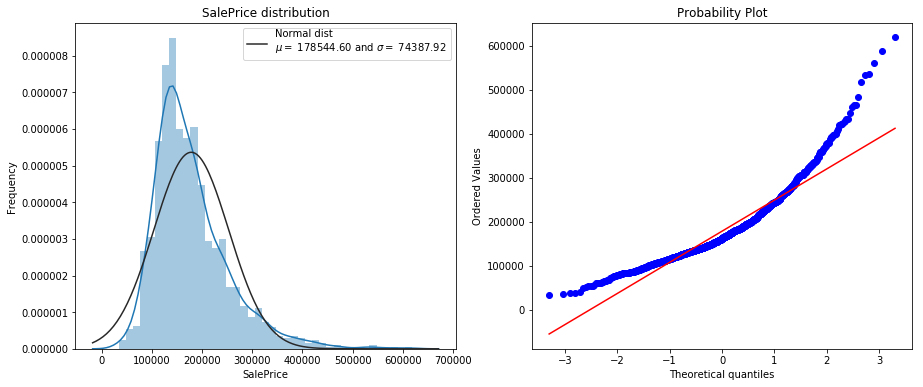

In [29]:
from scipy import stats
from scipy.stats import norm, skew

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(target, fit = norm, ax = axes[0]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print('skewness: {:.2f}'.format(skew(target)))

#Now plot the distribution
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],
            loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

#Get also the QQ-plot
res = stats.probplot(target, plot = axes[1])
plt.show()

* Podemos perceber que a variável alvo não se aproxima da distribuição normal, e tem uma cauda longa para a direita. É recomendável realizar uma transformação nos dados para aproximá-los de uma gaussiana, o que costuma melhorar a performance dos modelos. Para isso, será utilizada a transformação de Box-Cox

In [30]:
# Check the skew of all numerical features
skewed_feats = all_data[numerical_cols].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness[skewness['Skew'] > 0.75]


Skew in numerical features: 



,Skew
MiscVal,21.934924
LowQualFinSF,12.063406
3SsnPorch,11.352135
LandSlope,4.971924
Functional,4.952203
KitchenAbvGr,4.292019
BsmtFinSF2,4.154322
EnclosedPorch,3.994600
BsmtHalfBath,3.951078
ScreenPorch,3.937129


* Decidimos transformar apenas as features cuja skewness seja superior a 1. Assim:  

In [31]:
from scipy.special import boxcox1p
skewed_features = skewness[skewness['Skew'] > 1].index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
#     all_data[feat] = np.log1p(all_data[feat])

* Para a saída, fazemos a transformação log. Como o desafio no kaggle avalia o RMSLE, ao realizar a transformação log na saída, podemos avaliar os modelos utilizando o RMSE como métrica de erro, sem se preocupar em fazer a transformação inversa da variável, pois a transformação log já foi feita

In [32]:
target = np.log1p(target)

mu = 12.01 and sigma = 0.39
skewness: 0.00


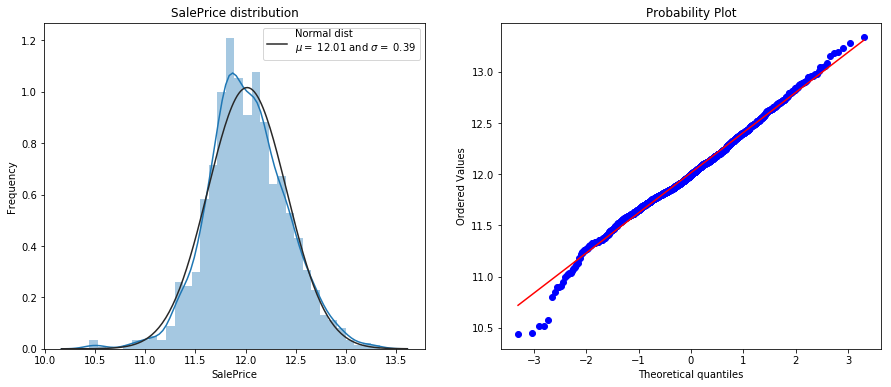

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
sns.distplot(target, fit = norm, ax = axes[0]);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(target)
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))
print('skewness: {:.2f}'.format(skew(target)))

#Now plot the distribution
axes[0].legend(['Normal dist \n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)],
            loc='best')
axes[0].set_ylabel('Frequency')
axes[0].set_title('SalePrice distribution')

#Get also the QQ-plot
res = stats.probplot(target, plot = axes[1])
plt.show()

In [34]:
data_train = pd.concat([all_data[all_data['SalePrice'] > 0].drop('SalePrice', axis = 1), target], axis = 1).dropna()
#data_train = data_train[data_train['SalePrice'] > 10]
target = data_train['SalePrice']
data_test = all_data[all_data['SalePrice'] < 0].copy()
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))

Train shape: (1448, 76)
Test shape: (1459, 76)


---

# Análise das variáveis numéricas

### Pela descrição do dataset, 'GarageCars' e 'GarageArea' parecem ser informações redundantes

,SalePrice,GarageArea,GarageCars
SalePrice,1.000000,0.668177,0.684840
GarageCars,0.684840,0.889933,1.000000
GarageArea,0.668177,1.000000,0.889933


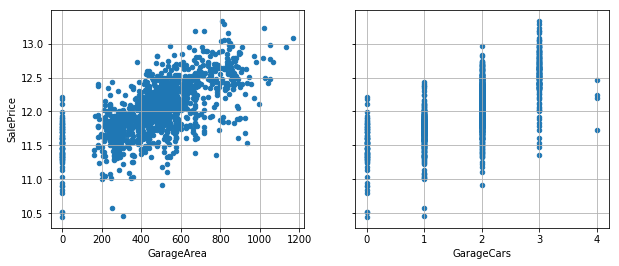

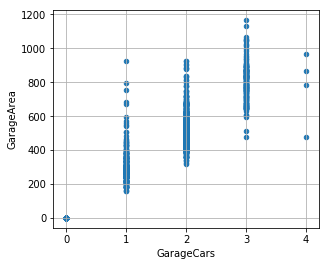

In [35]:
colnames = ['GarageArea', 'GarageCars']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(1, len(colnames), figsize=(10, 4))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i], sharey = True, grid = True)

data.plot.scatter(x = 'GarageCars', y = 'GarageArea', grid = True, figsize=(4.75, 4))

data_train[['SalePrice','GarageArea','GarageCars']].corr().sort_values(by = 'SalePrice', ascending = False)

* Podemos ver que 'GarageCars' apresenta uma correlação levemente superior com o preço de venda. No entanto, optamos por manter a variável GarageArea, por ser contínua, na esperança de que esta se encaixe melhor nos modelos

In [36]:
removed_cols.append('GarageCars')
data_train.drop('GarageCars', axis = 1, inplace = True)

### Buscando relação de 'Sales price' com as variáveis temporais

,SalePrice,YearBuilt,YearRemodAdd,GarageYrBlt,YrSold
SalePrice,1.000000,0.609820,0.576678,0.590544,0.033360
YearBuilt,0.609820,1.000000,0.591399,0.845548,0.013557
GarageYrBlt,0.590544,0.845548,0.605168,1.000000,0.009976
YearRemodAdd,0.576678,0.591399,1.000000,0.605168,0.037351
YrSold,0.033360,0.013557,0.037351,0.009976,1.000000


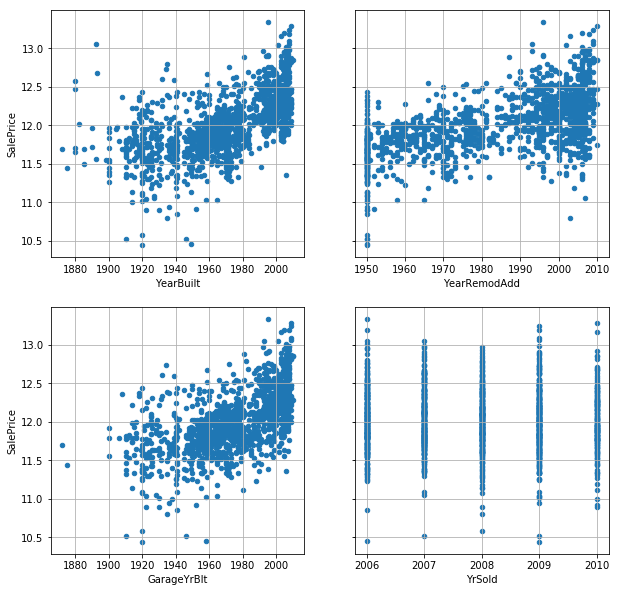

In [37]:
colnames = ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i//2, i%2], sharey = True, grid = True)
    
abs(data_train[['SalePrice','YearBuilt','YearRemodAdd','GarageYrBlt','YrSold']].corr()).sort_values(by = 'SalePrice', ascending = False)

### Realizando uma transformação nas variáveis que representam anos para que passem a representar idade no momento da venda

* newVar = YrSol - oldVar

In [38]:
data_train['AgeAtSale'] = data_train['YrSold'] - data_train['YearBuilt']
data_train['AgeRemodAtSale'] = data_train['YrSold'] - data_train['YearRemodAdd']
data_train['GarageAgeAtSale'] = data_train['YrSold'] - data_train['GarageYrBlt']

data_test['AgeAtSale'] = data_test['YrSold'] - data_test['YearBuilt']
data_test['AgeRemodAtSale'] = data_test['YrSold'] - data_test['YearRemodAdd']
data_test['GarageAgeAtSale'] = data_test['YrSold'] - data_test['GarageYrBlt']

removed_cols.extend(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'])
data_train.drop(['YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], axis = 1, inplace = True)
# keep salePrice as last column
data_train.drop(['SalePrice'], axis = 1, inplace = True)
data_train['SalePrice'] = target

,SalePrice,AgeAtSale,AgeRemodAtSale,GarageAgeAtSale,YrSold
SalePrice,1.000000,0.610334,0.579021,0.591178,0.033360
AgeAtSale,0.610334,1.000000,0.592737,0.846066,0.057514
GarageAgeAtSale,0.591178,0.846066,0.606305,1.000000,0.060425
AgeRemodAtSale,0.579021,0.592737,1.000000,0.606305,0.027173
YrSold,0.033360,0.057514,0.027173,0.060425,1.000000


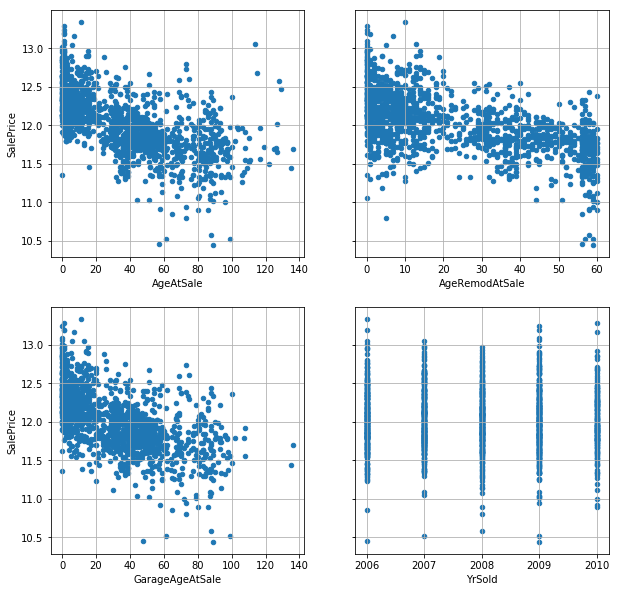

In [39]:
colnames = ['AgeAtSale','AgeRemodAtSale','GarageAgeAtSale','YrSold']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i//2, i%2], sharey = True, grid = True)
    
abs(data_train[['SalePrice','AgeAtSale','AgeRemodAtSale','GarageAgeAtSale','YrSold']].corr()).sort_values(by = 'SalePrice', ascending = False)

* Pode-se notar que a correlção entre as novas variáveis e o preço de venda é levemente superior (em módulo) do que as variáveis originais
* Pode-se também perceber que a variável YrSold tem baixa correlação SalePrice, logo podemos removê-la do dataset

In [40]:
removed_cols.append('YrSold')
data_train.drop('YrSold', axis = 1, inplace = True)

## Correlação entre demais variáveis

,SalePrice,TotalSF,OverallQual,GrLivArea,LotArea
SalePrice,1.000000,0.815902,0.815105,0.714128,0.409011
TotalSF,0.815902,1.000000,0.674258,0.860378,0.428950
OverallQual,0.815105,0.674258,1.000000,0.583466,0.176907
GrLivArea,0.714128,0.860378,0.583466,1.000000,0.388453
LotArea,0.409011,0.428950,0.176907,0.388453,1.000000


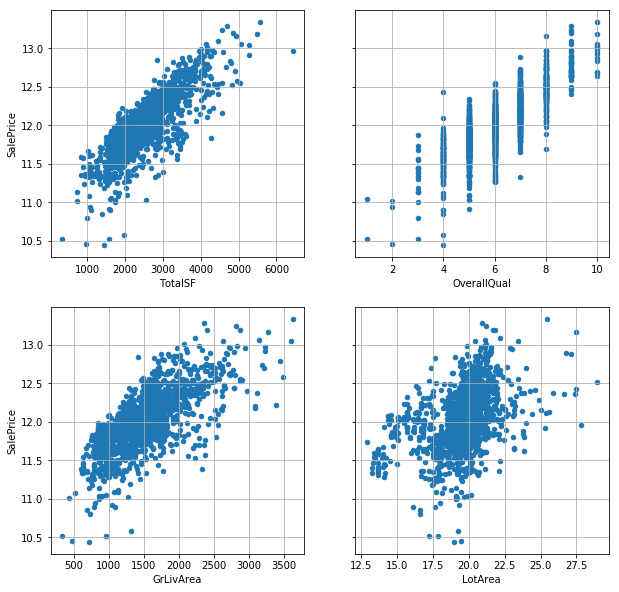

In [41]:
colnames = ['TotalSF','OverallQual','GrLivArea','LotArea']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i//2, i%2], sharey = True, grid = True)
    
abs(data_train[['SalePrice','TotalSF','OverallQual','GrLivArea','LotArea']].corr()).sort_values(by = 'SalePrice', ascending = False)

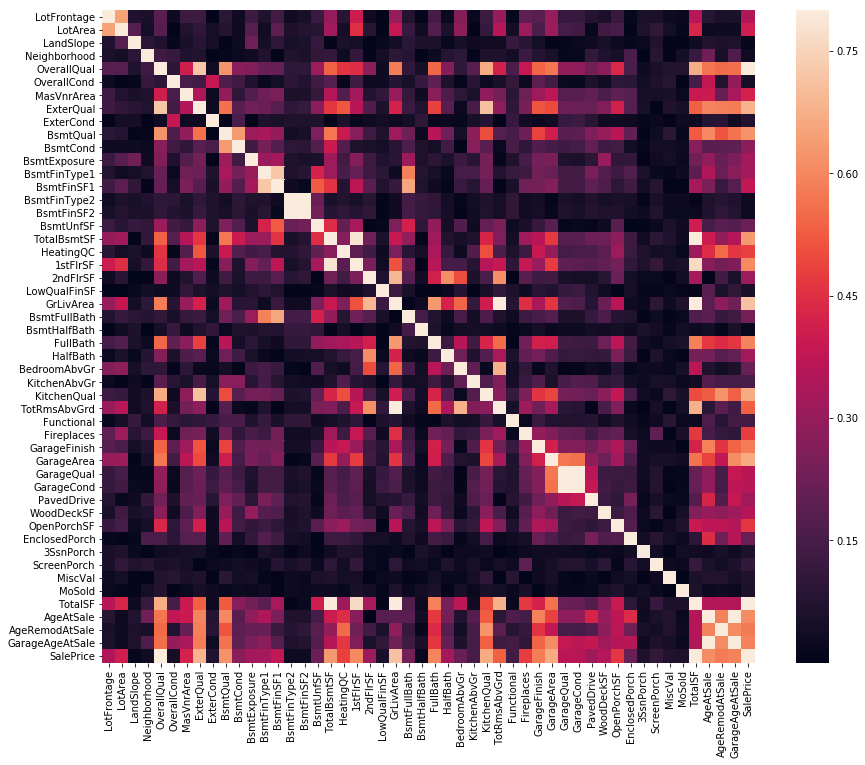

In [42]:
#correlation matrix
corrmat = abs(data_train.drop('Id', axis = 1).corr())
f, ax = plt.subplots(figsize=(15, 12))
sns.heatmap(corrmat, vmax=.8, square=True);

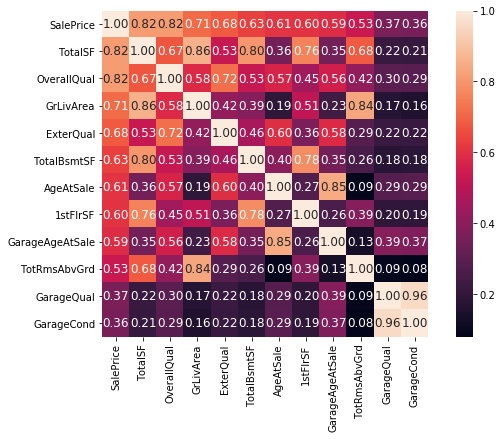

In [43]:
features = ['SalePrice','AgeAtSale','GarageAgeAtSale','TotalSF','GrLivArea','TotRmsAbvGrd','TotalBsmtSF','1stFlrSF','OverallQual','ExterQual','GarageQual','GarageCond']
fig, ax = plt.subplots(figsize=(10,6))
corrmat = abs(data_train[features].corr())
cols = corrmat.nlargest(len(features), 'SalePrice').index
cm = abs(np.corrcoef(data_train[cols].values.T))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

* É possível perceber algumas variáveis com alta correlação entre si. Podemos remover algumas dessas variáveis para simplificar o problema.
* Serão removidas as variáveis TotRmsAbvGrd, GarageAgeAtSale, pois apresentam maior correlação com o preço de venda do que a outra variável ao qual estão fortemente correlacionadas
* No caso da correlação entre TotalBsmtSF e 1stFlrSF, foi escolhido manter a variável 1stFlrSF, devido a menor presença de valores 0 (uma casa sempre terá o primeiro andar, mas não necessariamente terá um subsolo), isto pode ser observado nos gráficos abaixo
* GarageCond também pode ser removida devido à sua alta correlação com garageQual
* Por fim, a feature GrLivArea pode ser removida para dar lugar à nossa feature artificialmente gerada, TotalSF

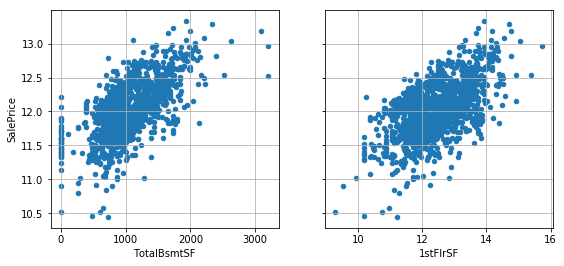

In [44]:
colnames = ['TotalBsmtSF', '1stFlrSF']
data = pd.concat([data_train['SalePrice'], data_train[colnames]], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(9, 4))
for i in range(len(colnames)):
    data.plot.scatter(x = colnames[i], y = 'SalePrice', ax = axes[i], sharey = True, grid = True)

In [45]:
data_train.drop(['TotRmsAbvGrd', 'GarageAgeAtSale', 'TotalBsmtSF', 'GrLivArea', 'GarageCond'], axis = 1, inplace = True)
removed_cols.extend(['TotRmsAbvGrd', 'GarageAgeAtSale', 'TotalBsmtSF', 'GrLivArea', 'GarageCond'])

* Removeremos também qualquer variável que apresente correlação menor do que 10% com o preço de venda

In [46]:
neighborhood_train = data_train['Neighborhood'] 
variables_correlation = abs(data_train.drop('Id', axis = 1).corr()['SalePrice']).sort_values(ascending = False)
data_train.drop(variables_correlation[variables_correlation <= 0.1].index, axis = 1, inplace = True)
# data_train = data_train[variables_correlation[variables_correlation > 0.1].index.append('Id')]
removed_cols.extend(variables_correlation[variables_correlation <= 0.1].index)

print(str(len(data_train.drop('Id', axis = 1).select_dtypes(include=['int64', 'float64']).columns)) + ' features numericas restantes: ')
print(data_train.drop('Id', axis = 1).select_dtypes(include=['int64', 'float64']).columns.values)

34 features numericas restantes: 
['LotFrontage' 'LotArea' 'OverallQual' 'MasVnrArea' 'ExterQual' 'BsmtQual'
 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinSF1' 'BsmtUnfSF'
 'HeatingQC' '1stFlrSF' '2ndFlrSF' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'Functional' 'Fireplaces'
 'GarageFinish' 'GarageArea' 'GarageQual' 'PavedDrive' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch' 'TotalSF' 'AgeAtSale'
 'AgeRemodAtSale' 'SalePrice']


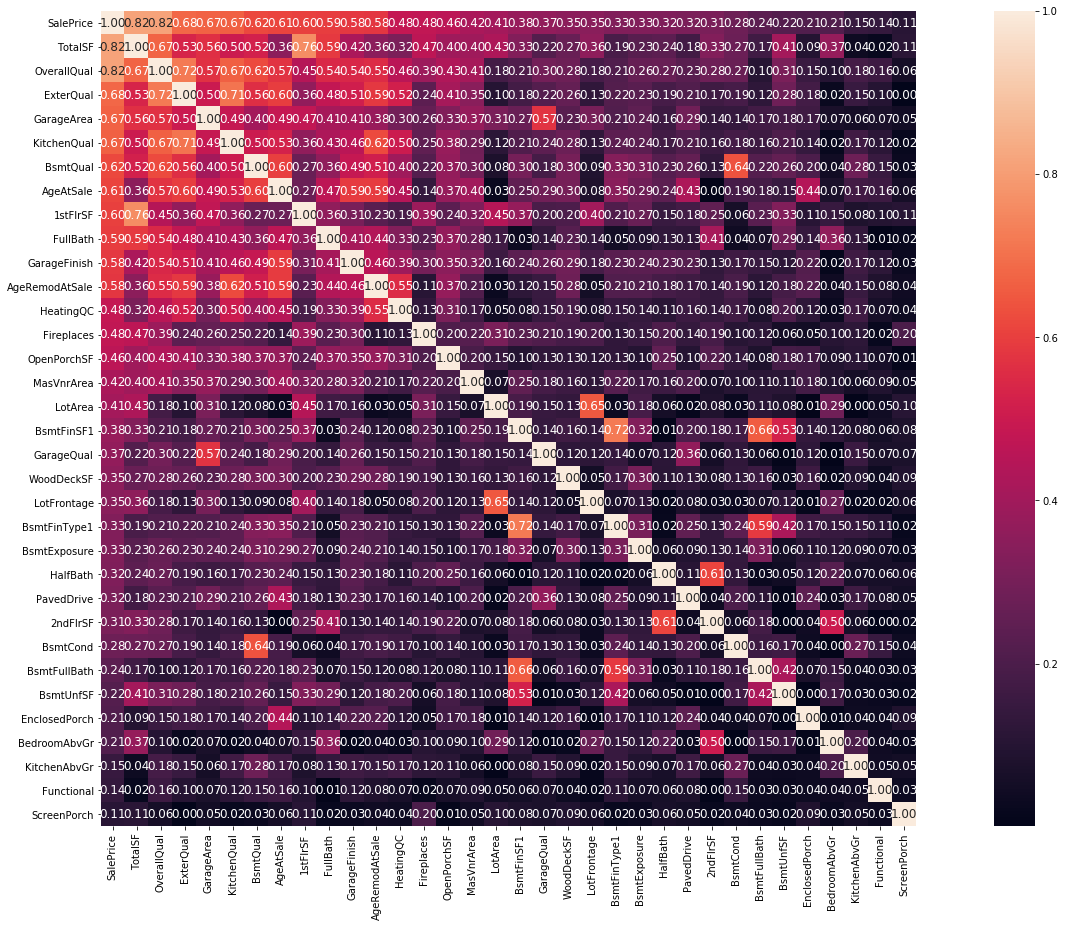

In [47]:
# Mapa de calor 
# correlação entre as variáveis numéricas
fig, ax = plt.subplots(figsize=(28,15))
k = 40
corrmat = abs(data_train.drop('Id', axis = 1).corr())
cols = corrmat.nlargest(k, 'SalePrice').index
cm = abs(np.corrcoef(data_train[cols].values.T))
sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 12}, yticklabels=cols.values, xticklabels=cols.values)

In [48]:
numerical_cols = data_train.drop(['Id', 'SalePrice'], axis = 1).select_dtypes(include=['int64', 'float64']).columns.values
categorical_cols = data_train.select_dtypes(exclude=['int64', 'float64']).columns.values
print('Numerical: ')
print(numerical_cols)
print('Categorical: ')
print(categorical_cols)

Numerical: 
['LotFrontage' 'LotArea' 'OverallQual' 'MasVnrArea' 'ExterQual' 'BsmtQual'
 'BsmtCond' 'BsmtExposure' 'BsmtFinType1' 'BsmtFinSF1' 'BsmtUnfSF'
 'HeatingQC' '1stFlrSF' '2ndFlrSF' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'Functional' 'Fireplaces'
 'GarageFinish' 'GarageArea' 'GarageQual' 'PavedDrive' 'WoodDeckSF'
 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch' 'TotalSF' 'AgeAtSale'
 'AgeRemodAtSale']
Categorical: 
['MSSubClass' 'MSZoning' 'Street' 'LotShape' 'LandContour' 'Utilities'
 'LotConfig' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle' 'RoofStyle'
 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType' 'Foundation'
 'Heating' 'CentralAir' 'Electrical' 'GarageType' 'SaleType'
 'SaleCondition']


In [49]:
neighborhood_test = data_test['Neighborhood']
data_test.drop(removed_cols, axis = 1, inplace = True)
all_data = pd.concat((data_train.drop(['SalePrice'], axis = 1), data_test))
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))

Train shape: (1448, 58)
Test shape: (1459, 58)


---

# Tratamento dos dados categóricos

In [50]:
print('O dataset contém {} variaveis categoricas: '.format(len(categorical_cols)))
categorical_cols

O dataset contém 23 variaveis categoricas: 


array(['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir',
       'Electrical', 'GarageType', 'SaleType', 'SaleCondition'],
      dtype=object)

In [51]:
all_data = pd.concat((data_train, data_test))

* Condition 1 e Contition2, assim como Exterior1st e Exterior2nd descrevem os mesmos valores, portanto podem ser codificados nas mesma variáveis dummy
* Para o restante das variáveis, podemos utilizar a função get_dummies do pandas, já que nossos dados já estão devidamente tratados. utilizando o parâmetro drop_first = True, evitamos criar colunas linearmente dependentes nesse processo
* As colunas Exterior1st e Exterior2nd apresentavam alguns erros de grafia em algumas classes, que foram corrigidos no código

In [52]:
def get_conditions_dummies(data):
    cond1 = pd.get_dummies(data['Condition1'])
    cond2 = pd.get_dummies(data['Condition2'])

    for cond in ('Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNe', 'RRNn'):
        if cond not in cond1.columns:
            cond1[cond] = 0
        if cond not in cond2.columns:
            cond2[cond] = 0

    return (((cond1 + cond2) > 0)*1).drop('RRNe', axis = 1).astype(int)

def get_exterior_dummies(data):
    data = data[['Exterior1st', 'Exterior2nd']].replace({'Brk Cmn': 'BrkComm', 'CmentBd': 'CemntBd', 'Wd Shng': 'WdShing'})
    ext1 = pd.get_dummies(data['Exterior1st'])
    ext2 = pd.get_dummies(data['Exterior1st'])

    for ext in ('AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Other', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing'):
        if ext not in ext1.columns:
            ext1[ext] = 0
        if ext not in ext2.columns:
            ext2[ext] = 0
    
    return (((ext1 + ext2) > 0)*1).drop('BrkComm', axis = 1).drop('Other', axis = 1).astype(int)

condition = get_conditions_dummies(all_data)
exterior = get_exterior_dummies(all_data)
all_data = pd.concat([pd.get_dummies(all_data.drop(['Condition1', 'Condition2', 'Exterior1st', 'Exterior2nd'], axis = 1), drop_first = True), condition, exterior], axis = 1)

In [53]:
data_train = all_data[all_data['SalePrice'] > 0].drop('Id', axis = 1)
data_test = all_data[all_data['SalePrice'] < 0].drop(['Id', 'SalePrice'], axis = 1)

In [54]:
print('Train shape: ' + str(data_train.shape))
print('Test shape: ' + str(data_test.shape))

Train shape: (1448, 146)
Test shape: (1459, 145)


In [55]:
data_test.isnull().any().sum()

0

In [56]:
data_test.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('uint8')], dtype=object)

### Terminamos o pré-processamento com 169 features

---

# Modelos

In [57]:
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

if 'SalePrice' in data_train.columns:
    data_train.drop('SalePrice', axis = 1, inplace = True)

* Primeiro, transformamos nossos dados para que possam servir de entrada aos modelos

In [58]:
x_scaler = RobustScaler()
y_scaler = RobustScaler()

x = x_scaler.fit_transform(data_train)
x_test = x_scaler.transform(data_test)
y = y_scaler.fit_transform(target.values.reshape(-1, 1))

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.25)

results = pd.DataFrame([], columns = ['mean', 'std'])
results

,mean,std


* Depois, definimos uma função de validação cruzada para avaliar o desempenho dos modelos 

In [59]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(data_train.values)
    rmse= np.sqrt(-cross_val_score(model, data_train.values, target.values.reshape(-1, 1), scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

* A seguir, criamos os modelos desejados

In [60]:
#from sklearn.linear_model import LinearRegression

#linear = make_pipeline(RobustScaler(), LinearRegression())

#score = rmsle_cv(linear)
# results.loc['Linear'] = [score.mean(), score.std()]

### Lasso Regression

In [61]:
from sklearn.linear_model import Lasso

lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005))

score = rmsle_cv(lasso)
results.loc['Lasso'] = [score.mean(), score.std()]

### ElasticNet

In [62]:
from sklearn.linear_model import ElasticNet

elasticNet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9))

score = rmsle_cv(elasticNet)
results.loc['ElasticNet'] = [score.mean(), score.std()]

### Ridge Regression

In [63]:
from sklearn.kernel_ridge import KernelRidge

KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

score = rmsle_cv(KRR)
results.loc['KRR'] = [score.mean(), score.std()]

### Gradient Boost

In [64]:
from sklearn.ensemble import GradientBoostingRegressor

GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber')

score = rmsle_cv(GBoost)
results.loc['GBoost'] = [score.mean(), score.std()]

### XGBoost

In [65]:
import xgboost as xgb

XGB = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

score = rmsle_cv(XGB)
results.loc['XGB'] = [score.mean(), score.std()]

### LGBoost

In [66]:
import lightgbm as lgb

LGB = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

score = rmsle_cv(LGB)
results.loc['LGB'] = [score.mean(), score.std()]

### Bayesian Ridge

In [67]:
from sklearn.linear_model import BayesianRidge

BayRidge = BayesianRidge()

score = rmsle_cv(BayRidge)
results.loc['BayRidge'] = [score.mean(), score.std()]

### Support Vector Regression

In [68]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, verbose=False, max_iter=-1)

score = rmsle_cv(svr)
results.loc['SVR'] = [score.mean(), score.std()]

### Random Forest Regressor

In [69]:
from sklearn.ensemble import RandomForestRegressor

RFR = RandomForestRegressor(n_estimators = 100)

score = rmsle_cv(RFR)
results.loc['RandomForest'] = [score.mean(), score.std()]

In [70]:
results.sort_values(by = 'mean')

,mean,std
ElasticNet,0.115362,0.002230
Lasso,0.115723,0.002242
BayRidge,0.116072,0.002182
LGB,0.120155,0.005095
XGB,0.121937,0.003847
GBoost,0.122620,0.005538
RandomForest,0.138613,0.003873
KRR,0.250258,0.024629
SVR,0.389949,0.015000


## Criando um Ensemble de modelos

In [71]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras import backend as K

class Ensemble():
    def __init__(self, models):
        K.clear_session()
        self.models = models
        self.ensemble_model = Sequential([Dense(1, activation = 'linear', input_dim = len(models))
#                                           Dense(1, activation = 'linear')
                                         ])
        self.ensemble_model.compile(optimizer='sgd', loss='mse')
        self.early_stopping = EarlyStopping(monitor='val_loss', patience=10)
        self.x_scaler = RobustScaler()
        self.y_scaler = RobustScaler()
        
    def fit(self, x, y):
        x = self.x_scaler.fit_transform(x.values)
        y = self.y_scaler.fit_transform(y.values.reshape(-1, 1))
        predictions = []
        i = 0
        for split in KFold(len(self.models), shuffle=True).split(x):
            self.models[i].fit(x[split[0]], y[:, 0][split[0]])
            predictions.append(self.models[i].predict(x))
            i += 1
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)

        history = self.ensemble_model.fit(predictions_reshape, y[:, 0], epochs = 1000, validation_split = 0.25, callbacks = [self.early_stopping], verbose = 0)
        plt.plot(history.history['loss'], label = 'Train')
        plt.plot(history.history['val_loss'], label = 'Validation')
        plt.ylim(0.95*min(min(history.history['loss']), min(history.history['val_loss'])), 1.1*max(history.history['val_loss']))
        plt.legend()
        plt.show()
    
    def predict(self, x):
        x = self.x_scaler.transform(x.values)
        predictions = []
        for i in range(len(self.models)):
            predictions.append(self.models[i].predict(x))
        predictions_reshape = [[]]*len(x)
        for i in range(len(x)):
            aux = [];
            for j in range(len(predictions)):
                aux.append(predictions[j][i])
            predictions_reshape[i] = aux
        predictions_reshape = np.array(predictions_reshape)
        
        return y_scaler.inverse_transform(self.ensemble_model.predict(predictions_reshape)).reshape(1, -1)[0]
        

Using TensorFlow backend.


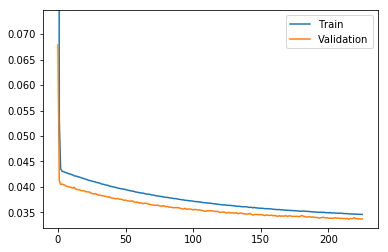

0.09074765992232774

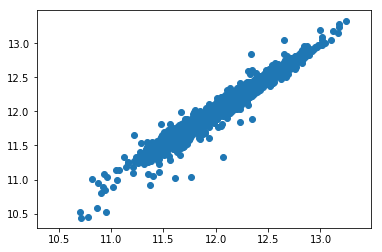

In [72]:
models = [
    BayesianRidge(),
    Lasso(alpha =0.0005),
    ElasticNet(alpha=0.0005, l1_ratio=.9),
    lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
    
]

ensemble = Ensemble(models)
ensemble.fit(data_train, target)
predictions = ensemble.predict(data_train)
plt.scatter(predictions, target)
plt.xlim(min(min(predictions), min(target)) - 0.15, max(max(predictions), max(target)) + 0.15)
plt.ylim(min(min(predictions), min(target)) - 0.15, max(max(predictions), max(target)) + 0.15)
np.sqrt(mean_squared_error(predictions, target))

# Submissão dos resultados

* Selecionando o modelo

In [73]:
model = ensemble

In [74]:
submission = pd.DataFrame()
submission['Id'] = test_ids

In [75]:
#predictions = y_scaler.inverse_transform(model.predict(x_test).reshape(-1, 1))
predictions = model.predict(data_test)
final_predictions = np.expm1(predictions) * neighborhood_test/100

submission['SalePrice'] = final_predictions

In [76]:
submission.to_csv('submission.csv', index=False)